**Program Digitalent FGA KOMINFO**

Nama: Fajar Wulan A | [Profil Dicoding](https://www.dicoding.com/users/fwulana/academies)

Program yang akan dibuat kali ini adalah klasifikasi gambar yang mampu mengenali gestur tangan menjadi gunting, batu, dan kertas. Selanjutnya, agar program dapat berjalan maka perlu melakukan beberapa tahapan. Tahapan pertama, mengunduh data yang telah disediakan Dicoding pada link [ini](https://https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip) menggunakan perintah wget.

In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip

--2021-07-24 20:37:29--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘rockpaperscissors.zip’

rockpaperscissors.z 100%[===================>] 307.92M  2.65MB/s    in 81s     

2021-07-24 20:38:51 (3.81 MB/s) - ‘rockpaperscissors.zip’ saved [322873683/322873683]



In [26]:
#import library yang akan digunakan pada model ini
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing import image

Setelah unduhan selesai, maka tahap selanjutnya adalah mengekstrak file zip menjadi sebuah folder.

In [3]:
import zipfile, os
local_zip = '/content/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

Kemudian, tahap selanjutnya mendefinisikan nama folder untuk data gambar gunting, batu, dan kertas serta mengetahui total dari gambar yang tersedia.

In [4]:
base_dir = '/content/rockpaperscissors/rps-cv-images'

scissors_dir = os.path.join(base_dir, 'scissors')
paper_dir = os.path.join(base_dir, 'paper')
rock_dir = os.path.join(base_dir, 'rock')

print('Total gambar gunting:', len(os.listdir(scissors_dir)))
print('Total gambar kertas:', len(os.listdir(paper_dir)))
print('Total gambar batu:', len(os.listdir(rock_dir)))

Total gambar gunting: 750
Total gambar kertas: 712
Total gambar batu: 726


Tahap selanjutnya, membuat objek untuk image data generator dan membuat proporsi data dimana 60% data training, 40% data validation. Selain itu, melakukan pelabelan data berdasarkan folder.

In [5]:
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 20,
                    horizontal_flip = True,
                    shear_range = 0.2,
                    zoom_range= 0.2,
                    fill_mode = 'nearest',
                    validation_split = 0.4)
 
train_generator = train_datagen.flow_from_directory(
          base_dir,
          target_size = (100,150),  
          class_mode = 'categorical',
          shuffle = True,
          subset = 'training')

validation_generator = train_datagen.flow_from_directory(
        base_dir, 
        target_size=(100, 150),  
        subset='validation',
        shuffle = True,
        class_mode='categorical')

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


Setelah data siap, kemudian membangun model jaringan syaraf tiruan (CNN) menggunakan sequential.

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 148, 32)       896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 15, 512)        5

Selanjutnya, melakukan kompilasi pada objek model dan menentukan fungsi loss serta optimizer.

In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Pada model ini menggunakan fungsi callback untuk melakukan penghentian apabila pelatihan model sudah mencapai target 99% dan juga menggunakan fungsi learning rate.

In [27]:
class myCallback(tf.keras.callbacks.Callback):
   def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy') >= 0.99 and logs.get('val_accuracy') >= 0.99):
          print("\nAkurasi telah mencapai >=99%!")
          self.model.stop_training = True
callbacks = myCallback()

lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=15, min_lr=0.00001, verbose=2)

Setelah menentukan loss function dan optimizer, tahap selanjutnya melatih model dengan menggunakan model fit.

In [9]:
history = model.fit(train_generator,
                    steps_per_epoch=25,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps=5,
                    callbacks=[callbacks, lr],
                    verbose=2)

Epoch 1/30
25/25 - 36s - loss: 1.0291 - accuracy: 0.4288 - val_loss: 0.7001 - val_accuracy: 0.6125
Epoch 2/30
25/25 - 33s - loss: 0.5452 - accuracy: 0.7740 - val_loss: 0.3471 - val_accuracy: 0.8938
Epoch 3/30
25/25 - 33s - loss: 0.3615 - accuracy: 0.8675 - val_loss: 0.5044 - val_accuracy: 0.8188
Epoch 4/30
25/25 - 33s - loss: 0.3112 - accuracy: 0.9039 - val_loss: 0.2195 - val_accuracy: 0.9250
Epoch 5/30
25/25 - 34s - loss: 0.2714 - accuracy: 0.9013 - val_loss: 0.3041 - val_accuracy: 0.9062
Epoch 6/30
25/25 - 34s - loss: 0.2446 - accuracy: 0.9143 - val_loss: 0.2204 - val_accuracy: 0.9000
Epoch 7/30
25/25 - 35s - loss: 0.2416 - accuracy: 0.9187 - val_loss: 0.1530 - val_accuracy: 0.9500
Epoch 8/30
25/25 - 33s - loss: 0.2732 - accuracy: 0.8870 - val_loss: 0.3429 - val_accuracy: 0.8750
Epoch 9/30
25/25 - 35s - loss: 0.1847 - accuracy: 0.9375 - val_loss: 0.3898 - val_accuracy: 0.8938
Epoch 10/30
25/25 - 34s - loss: 0.1785 - accuracy: 0.9312 - val_loss: 0.2022 - val_accuracy: 0.9187
Epoch 11/

Setelah melakukan pelatihan model maka tahap selanjutnya melakukan evaluasi model menggunakan grafik dari fungsi matplotlib untuk mengetahui pergerakan besaran nilai akurasi training dan validasi.

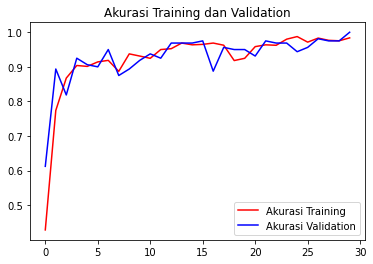

<Figure size 432x288 with 0 Axes>

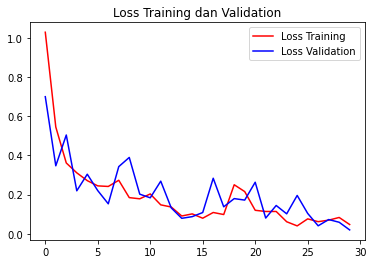

<Figure size 432x288 with 0 Axes>

In [14]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Akurasi Training')
plt.plot(epochs, val_acc, 'b', label='Akurasi Validation')
plt.title('Akurasi Training dan Validation')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Loss Training')
plt.plot(epochs, val_loss, 'b', label='Loss Validation')
plt.title('Loss Training dan Validation')
plt.legend(loc=0)
plt.figure()
plt.show()

Menampilkan kelas dan atribut pada data menggunakan fungsi train generator dan class indices

In [10]:
print(train_generator.class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}


Tahapan selanjutnya, melakukan uji coba model dengan mengunggah gambar. Model akan menentukan apakah gambar berbentuk gunting, batu, atau kertas.

Saving Screen Shot 2021-07-25 at 04.18.28.png to Screen Shot 2021-07-25 at 04.18.28.png
Screen Shot 2021-07-25 at 04.18.28.png
rock


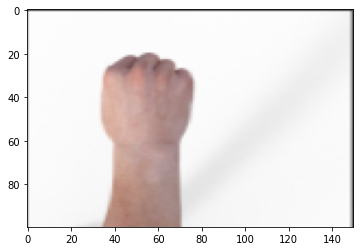

In [25]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for up in uploaded.keys():

  path = up
  img = image.load_img(path, target_size=(100,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  output = np.argmax(classes) 
 
  print(up)
  if classes[0, 0] == 1:
    print('paper')
  elif classes[0, 1] == 1:
    print('rock')
  elif classes[0, 2] == 1:
    print('scissors')